In [2]:
import torch
from torch import nn

# AlexNet 网络结构定义
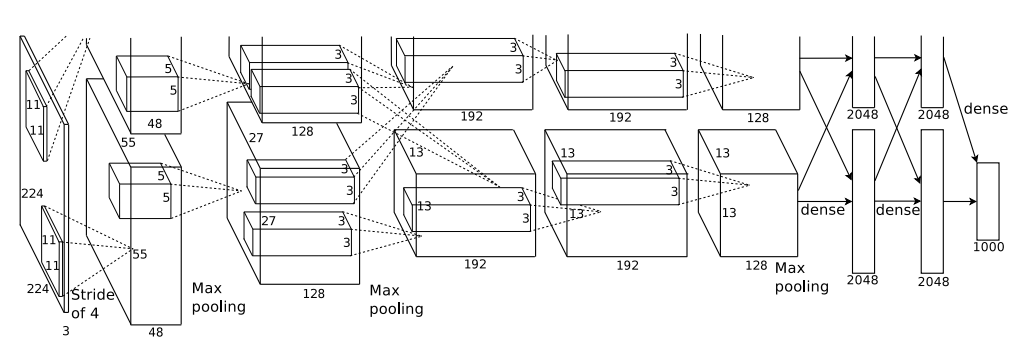

卷积输出形状的计算公式：

$$ \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor $$

- $n_h$：表示输入图像（特征图）的高
- $k_h$：表示卷积核的高
- $p_h$：表示高方向的填充
- $s_h$：表示高方向的步幅
- $\lfloor \ \rfloor $：表示向下取整

一般来说，高宽方向上的步幅是相等的，所以代码中直接就写一个数字。
一般来说，高宽填充相等，填充在高度方向上表示上下都填充，而公式中表示的是总的填充，所以代码中的 $padding*2$ 就表示公式中的 $p_h$ 了。

图中因为历史的原因，用于训练模型的GPU内存太小，将模型的卷积拆分成两个部分，看起来很怪异。现在很少出现将模型拆分的情况，所以这里代码实现就将它们合并到了一起。

In [3]:
class MyAlexNet(nn.Module):
    def __init__(self, num_classes = 1000, dropout = 0.5):
        super().__init__()
        self.conv_layer = nn.Sequential(
            # (224 - 11 + 2*2 + 4)/4 = 55
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), # b x 96 x 55 x 55
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            # maxpool 不改变通道数，(55 - 2 + 2) / 2 = 27
            nn.MaxPool2d(3, stride=2), # b x 96 x 27 x 27
            
            # 让 kernel size 等于 2*padding + 1，保持特征图的大小不变
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # b x 256 x 27 x 27 
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2), # b x 256 x 13 x 13
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # b x 384 x 13 x 13
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # b x 384 x 13 x 13
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # b x 256 x 13 x 13
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2), # b x 256 x 6 x 6
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        return self.fc_layer(x)

In [4]:
a = torch.rand((1, 3, 224, 224))

In [5]:
myNet = MyAlexNet()
myNet(a).shape

torch.Size([1, 1000])

# torchvision 中的实现
在 torchvision 中对AlexNet进行了修改，其实现如下：

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
tNet = AlexNet()
tNet(a).shape

torch.Size([1, 1000])

In [8]:
b = torch.rand((1, 3, 227, 227))
tNet(b).shape

torch.Size([1, 1000])

可以看到其卷积层和原始的实现稍有区别，通道数稍有不同。

去掉了 LRN 层。LRN 层在 VGG 论文中被通过实验证明没什么多大作用，但是却增加了内存消耗核计算时间。

同时加了一个全局平均池化层在卷积层之后，使得我们可以输入任意大小的图像，在卷积层后的全局平均池化层固定输出 `256 * 6 * 6` 大小，全连接层不用动。

# 模型可视化

In [9]:
import netron

my_net_onnx_path = "my_alexnet_.onnx"
torch.onnx.export(myNet, a, my_net_onnx_path)
netron.start(my_net_onnx_path)

C:\Users\27815\anaconda3\envs\pytorch_models\lib\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
C:\Users\27815\anaconda3\envs\pytorch_models\lib\site-packages\torch\onnx\utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C._jit_pass_onnx_graph_shape_type_inference(
C:\Users\27815\anaconda3\envs\pytorch_models\lib\site-packages\torch\onnx\utils.py:687: UserWarning: Constant folding - Only steps=1 can be cons

Serving 'my_alexnet_.onnx' at http://localhost:8080


('localhost', 8080)

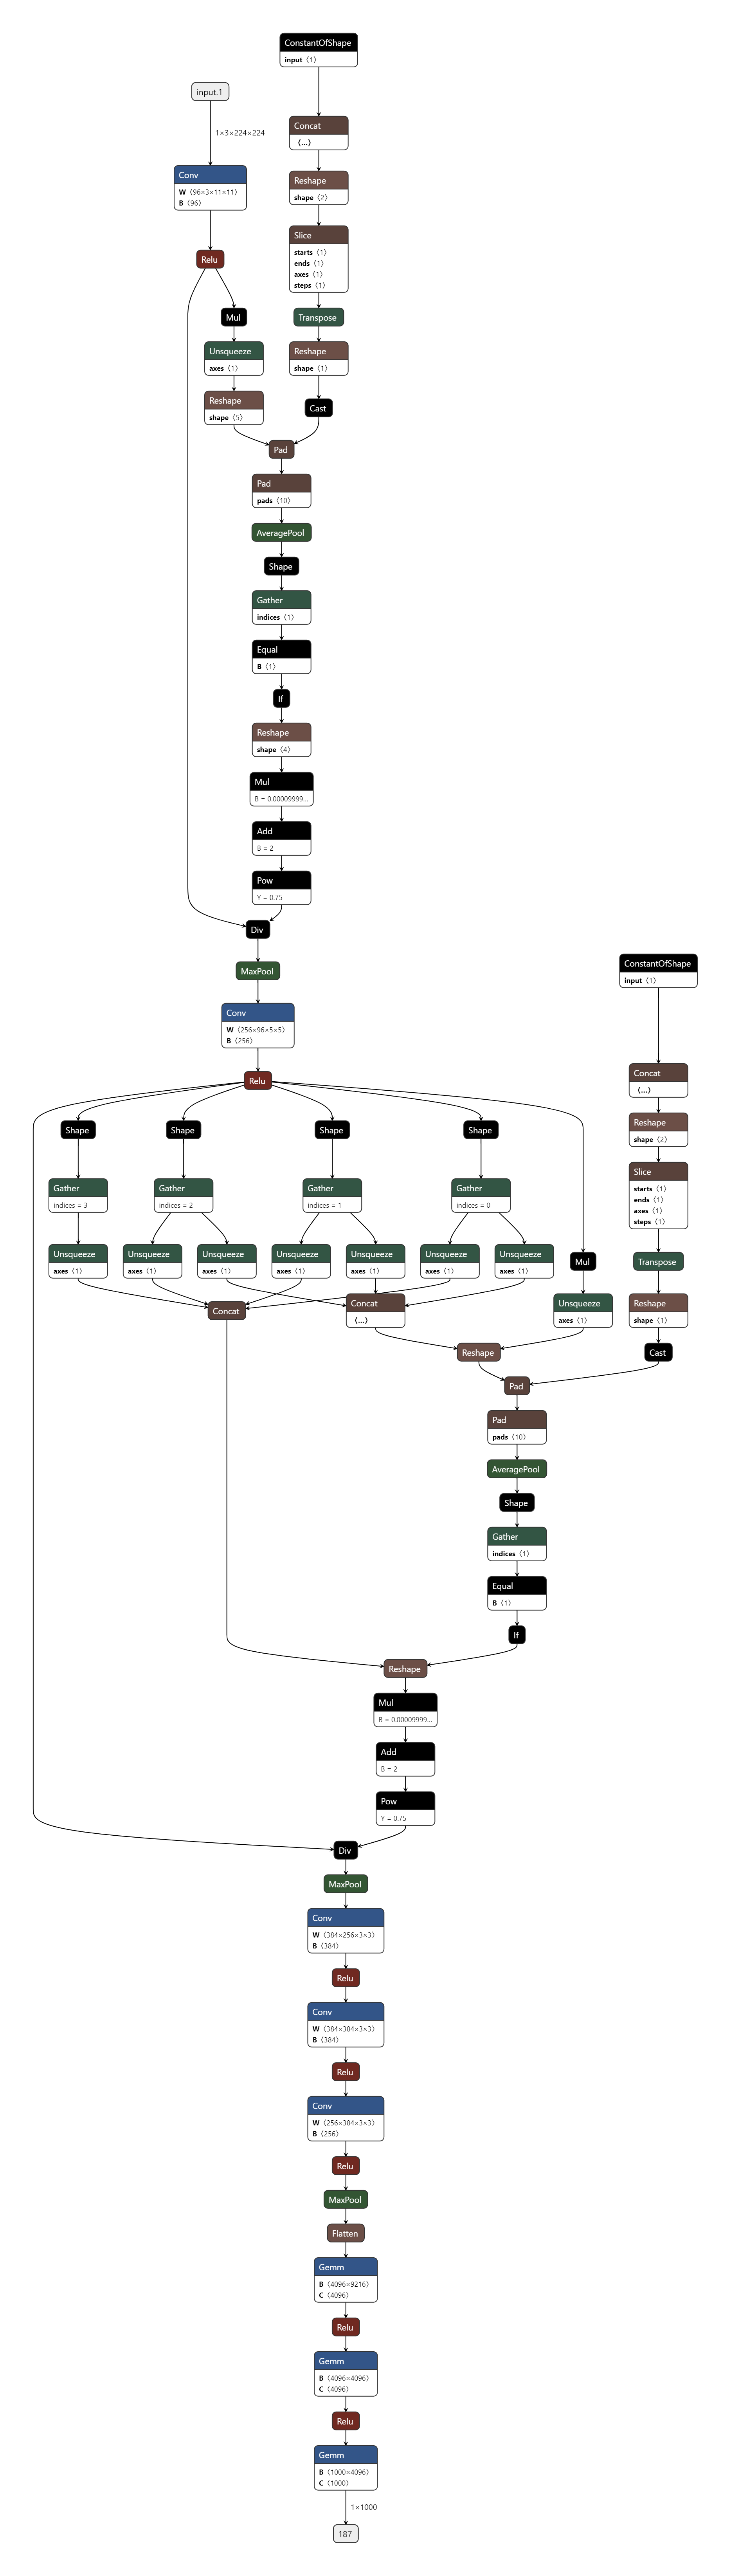

In [10]:
torch_net_onnx_path = "torch_alexnet_.onnx"
torch.onnx.export(tNet, a, torch_net_onnx_path)
netron.start(torch_net_onnx_path)

Serving 'torch_alexnet_.onnx' at http://localhost:8080


('localhost', 8080)

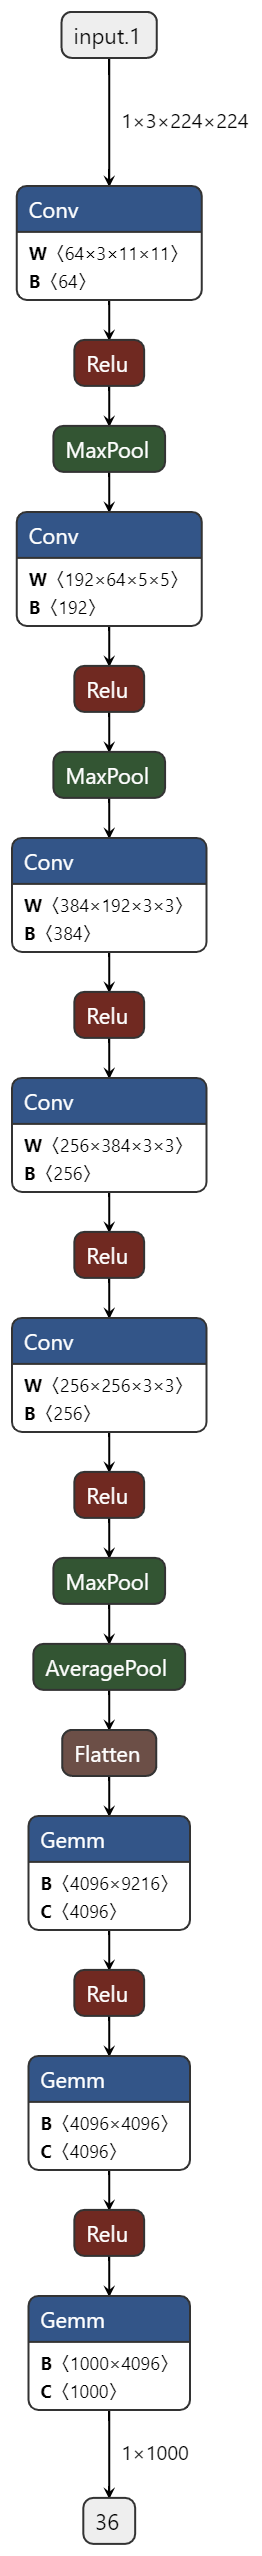

# AlexNet 要点

1. AlexNet 取得了 ImageNet 2012 分类比赛的冠军，它的效果比第二名使用传统机器学习的方法好的多，引发了深度学习的研究热潮
2. 使用 ReLU 激活函数能使得模型训练时有效快速的收敛
3. 使用 GPU 的并行计算能力能加快模型的训练
4. dropout 能有效缓解全连接层的过拟合的情况

In [12]:
aa = torch.rand(1,3,1,1)
tNet(a).shape

torch.Size([1, 1000])

In [24]:
aa = torch.rand(1,3,3,3)
bb = nn.AdaptiveAvgPool2d((2,2))(aa)